# U4 - Abdullah Barhoum (5041774) - Katharina Müller (5284090)

# Assignment 4: Hough Transform

In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color, filters
import numpy as np
from skimage.draw import line, circle_perimeter
import math 
from collections import defaultdict
import cv2


## Ex. 4.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) **OR** circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

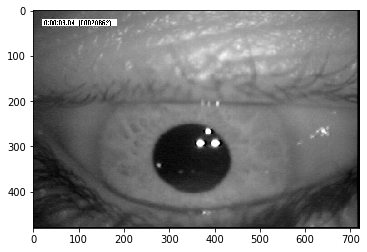

In [28]:
circle_image = io.imread('images/eye_tracking/0090.jpeg', 0)
img_gray = color.rgb2gray(circle_image)
plt.imshow(img_gray, cmap = plt.cm.gray)

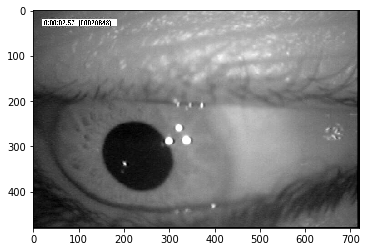

In [29]:
eye_left = io.imread('images/eye_tracking/0076.jpeg', 0)
eye_left_gray = color.rgb2gray(eye_left)
plt.imshow(eye_left_gray, cmap = plt.cm.gray)

## OPTION 2: circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

In [15]:
# voting:
def voting(img, h_step_size=1, w_step_size=1, r_step_size=1):
    H, W = img.shape
    R = min(H, W) // 2
    acc = np.zeros((H, W, R))
    for r in range(0, R, r_step_size):
        for y in range(r, H - r, h_step_size):
            for x in range(r, W - r, w_step_size):
                acc[y, x, r] += edges[circle_perimeter(y, x, r, method='andres')].sum()
    return acc

In [16]:
def get_max(arr, count = 10):
    res = arr.copy()
    output = []
    for i in range(count):
        indexes = np.unravel_index(np.argmax(res), res.shape)
        res[indexes] = 0
        output.append(indexes)
    return output

### example on whole image

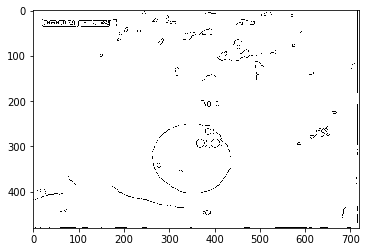

In [62]:
edges_whole = feature.canny(img_gray, sigma=1.5)
plt.imshow(edges_whole, cmap = 'binary')

In [63]:
res_whole = voting(edges_whole)

IndexError: index 340 is out of bounds for axis 1 with size 340

In [56]:
result_img_whole = color.gray2rgb(img_gray)
for y, x, r in get_max(res_whole):
    result_img[circle_perimeter(y, x, r)] = np.array([1, 0, 0])
plt.imshow(result_img_whole)

NameError: name 'res_whole' is not defined

### example on crop that works on all images

In [61]:
crop_img_2 = eye_left_gray[200:420, 110:450]
#plt.imshow(crop_img_2, cmap='gray')
crop_img_2.shape

(220, 340)

In [59]:
edges = feature.canny(crop_img_2, sigma=1.5)
#plt.imshow(edges, cmap = 'binary')

In [50]:
res = voting(edges,2,2,2)

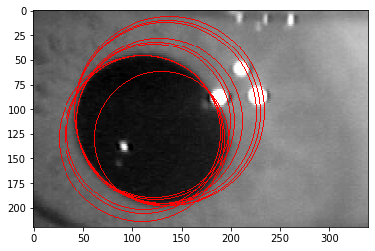

In [36]:
result_img = color.gray2rgb(crop_img_2)
for y, x, r in get_max(res):
    result_img[circle_perimeter(y, x, r)] = np.array([1, 0, 0])
plt.imshow(result_img)

### optimisation by cropping image further

In [57]:
crop_img = img_gray[240:410, 240:450]
#plt.imshow(crop_img, cmap='gray')
crop_img.shape

(170, 210)

In [58]:
crop_edges = feature.canny(crop_img, sigma=1.5)
#plt.imshow(crop_edges, cmap = 'binary')

In [20]:
crop_res = voting(crop_edges)

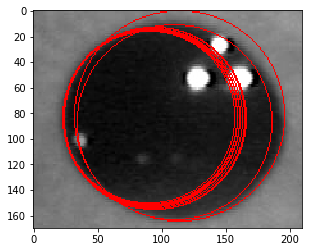

In [21]:
crop_result_img = color.gray2rgb(crop_img)
for y, x, r in get_max(crop_res):
    crop_result_img[circle_perimeter(y, x, r)] = np.array([1, 0, 0])
plt.imshow(result_img)

# Ex. 3.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import sobel_h, sobel_v, gaussian
from skimage.feature import canny
from skimage.color import rgb2gray
from skimage.draw import circle
import numpy as np

full_circle = 2 * np.pi


def get_theta(img, gauss_sigma):
    blurred = gaussian(img, gauss_sigma)
    g_x, g_y = sobel_v(blurred), sobel_h(blurred)
    return (np.arctan2(g_y, g_x) + full_circle) % full_circle


def edges(img, gauss_sigma):
    return canny(img, gauss_sigma).nonzero()


def create_R_table(img, num_steps, gauss_sigma=1):
    theta = get_theta(img, gauss_sigma)

    edge_y, edge_x = edges(img, gauss_sigma)
    cy, cx = edge_y.mean(), edge_x.mean()

    step_size = full_circle / num_steps
    table = {index: [] for index in range(num_steps)}
    for y, x in zip(edge_y, edge_x):
        v = (cy - y, cx - x)
        bin_index = int(theta[y, x] // step_size)
        table[bin_index].append(v)
    return table


def GHT(img, table, gauss_sigma=1):
    accumulator = np.zeros_like(img)
    H, W = accumulator.shape

    theta = get_theta(img, gauss_sigma)
    edge_y, edge_x = edges(img, gauss_sigma)
    num_steps = len(table)
    step_size = full_circle / num_steps
    for y, x in zip(edge_y, edge_x):
        bin_index = int(theta[y, x] // step_size)
        for (offset_y, offset_x) in table[bin_index]:
            cy = int(y + offset_y)
            cx = int(x + offset_x)
            if H > cy >= 0 and W > cx >= 0:
                accumulator[cy, cx] += 1

    return accumulator

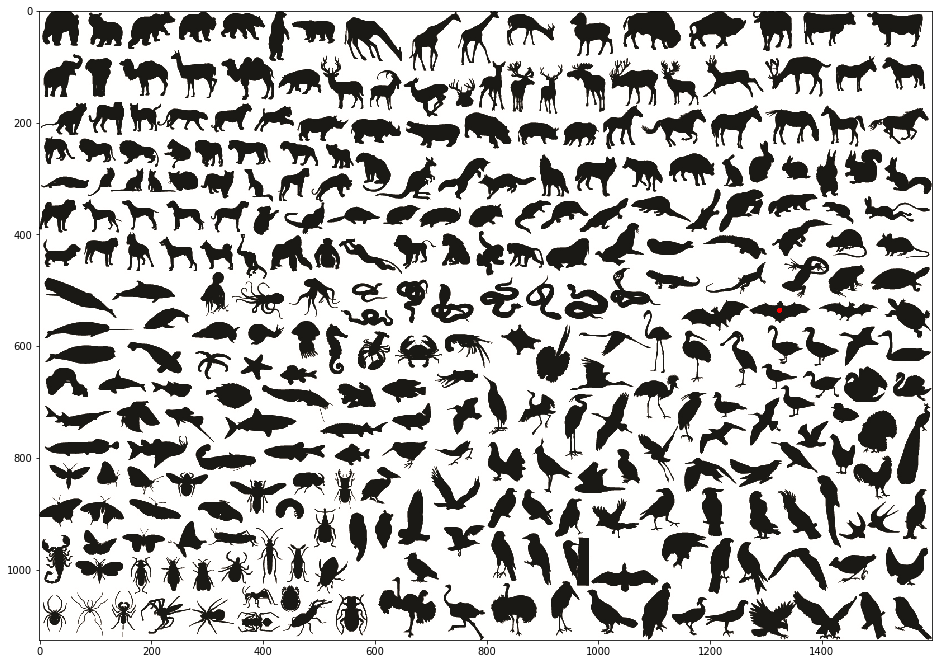

In [10]:
animals = io.imread('images/animals.png')
bat = animals[519:561, 1271:1381]

angle_steps = 180
table = create_R_table(rgb2gray(bat), angle_steps)
acc = GHT(rgb2gray(animals), table)

cy, cx = np.unravel_index(np.argmax(acc), acc.shape)
animals[circle(cy, cx, 5)] = np.array([255, 0, 0])

plt.figure(figsize=(16, 16))
plt.imshow(animals)
plt.show()

## BONUS 
* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**BONUS**)